In [14]:
import os
from os import path 
from time import time

import jax
import jax.numpy as jnp
import numpy as np 

import numpy as np 

from astropy import units as u
from astropy import constants as const 

from functools import partial

# turn on 64 bit operations
jax.config.update("jax_enable_x64", True)

In [15]:
# test to see what device we are running on 
try: 
    from jax.lib import xla_bridge
    print(xla_bridge.get_backend().platform)
except: 
    print(xla_bridge.get_backend().platform)

cpu


In [16]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 12
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update({"text.usetex": True})

In [17]:
import peytonites
from peytonites import (
    Distribution, SimState,
    kpc_to_cm, cm_to_kpc, 
    lyr_to_cm, cm_to_lyr, 
    au_to_cm, cm_to_au
)

# Vector Simulation

**Running this will replace/overwrite the last outputs**

Using vectorized operations in this implementation significantly reduces computation time compared to the double for-loop, but at the cost of massively increased memory usage due to storing large intermediate arrays for pairwise distances and accelerations.



In [18]:
def vector_simulation(n_steps, sim_init_cond, out_dir, verbose=False):
    
    G = sim_init_cond.G # cm^3 / (g s^2)
    dt = sim_init_cond.dt
    nsteps = n_steps #sim_init_cond.nsteps
    out_interval = sim_init_cond.out_interval
    soft = sim_init_cond.soft
    
    init_dist = sim_init_cond.distribution
    
    number_particles = init_dist.N
    
    x_arr = init_dist.x.copy()
    y_arr = init_dist.y.copy()
    z_arr = init_dist.z.copy()
    
    vx_arr = init_dist.vx.copy()
    vy_arr = init_dist.vy.copy()
    vz_arr = init_dist.vz.copy()
    
    mass_arr = init_dist.m.copy()
    #----------------------------------------
    for step in range(nsteps): 
        dx = x_arr[:, np.newaxis] - x_arr
        dy = y_arr[:, np.newaxis] - y_arr
        dz = z_arr[:, np.newaxis] - z_arr

        
        # Avoid division by zero by adding softening length
        r_squared = dx**2 + dy**2 + dz**2 + soft**2
        np.fill_diagonal(r_squared, 1)  # Avoid self-interaction
        
        r = np.sqrt(r_squared)
        r_cubed = r_squared * r
        
        # Compute accelerations
        a = -G * mass_arr / r_cubed
        np.fill_diagonal(a, 0)  
        ax_arr = np.sum(a * dx, axis=1)
        ay_arr = np.sum(a * dy, axis=1)
        az_arr = np.sum(a * dz, axis=1)
        
        
        # Update velocities and positions
        vx_arr += ax_arr * dt
        vy_arr += ay_arr * dt
        vz_arr += az_arr * dt
        
        x_arr += vx_arr * dt
        y_arr += vy_arr * dt
        z_arr += vz_arr * dt
    #----------------------------------------

        if step % out_interval == 0:
            if verbose:
                print(step) 
            
            step_params = sim_init_cond.copy()
            if step > 0:
                step_dist = Distribution.from_arrays(
                    x_arr, y_arr, z_arr, 
                    vx_arr, vy_arr, vz_arr,
                    mass_arr, name=init_dist.name)

                step_params = sim_init_cond.copy()
                step_params.distribution = step_dist                
            
            step_filename = 'step_{:08d}.dat'.format(step)
            step_path = path.join(out_dir, step_filename)
            
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            
            step_params.write(step_path)
    if verbose:
        print(step) 
    #----------------------------------------
    return 
    

# JIT-TED jax Simulation

**Running this will replace/overwrite the last outputs**

Using jitted operations in this implementation significantly reduces computation time. Go JAX
Note for now I removed some jax arrays just have as numpy arrays to see what effect this has on memory footprint and runtime


In [19]:
@partial(jax.jit, static_argnums=(7,8,9,))
def step_fun(x_arr, y_arr, z_arr, vx_arr, vy_arr, vz_arr, mass_arr, soft, G, dt):
    
    dx = x_arr[:, None] - x_arr
    dy = y_arr[:, None] - y_arr
    dz = z_arr[:, None] - z_arr
            
    # Avoid division by zero by adding softening length
    r_squared = dx**2 + dy**2 + dz**2 + soft**2
    r_squared = jnp.fill_diagonal(r_squared, 1, inplace=False)  # Avoid self-interaction
        
    r = jnp.sqrt(r_squared)
    r_cubed = r_squared * r
        
    # Compute accelerations
    a = -G * mass_arr / r_cubed
    a = jnp.fill_diagonal(a, 0, inplace=False)
        
    ax_arr = np.sum(a * dx, axis=1)
    ay_arr = np.sum(a * dy, axis=1)
    az_arr = np.sum(a * dz, axis=1)
        
        
    # Update velocities and positions
    vx_arr += ax_arr * dt
    vy_arr += ay_arr * dt
    vz_arr += az_arr * dt
        
    x_arr += vx_arr * dt
    y_arr += vy_arr * dt
    z_arr += vz_arr * dt
    #----------------------------------------
    return x_arr, y_arr, z_arr, vx_arr, vy_arr, vz_arr,

def jax_simulation(n_steps, sim_init_cond, out_dir, verbose=False):
    
    G = sim_init_cond.G # cm^3 / (g s^2)
    dt = sim_init_cond.dt
    nsteps = n_steps #sim_init_cond.nsteps
    out_interval = sim_init_cond.out_interval
    soft = sim_init_cond.soft
    init_dist = sim_init_cond.distribution
    number_particles = init_dist.N
    
    x_arr = np.array(init_dist.x.copy())
    y_arr = np.array(init_dist.y.copy())
    z_arr = np.array(init_dist.z.copy())
    
    vx_arr = np.array(init_dist.vx.copy())
    vy_arr = np.array(init_dist.vy.copy())
    vz_arr = np.array(init_dist.vz.copy())
    
    mass_arr = np.array(init_dist.m.copy())
    #----------------------------------------
    for step in range(nsteps): 
        x_arr, y_arr, z_arr, vx_arr, vy_arr, vz_arr, = step_fun(x_arr, y_arr, z_arr, vx_arr, vy_arr, vz_arr, mass_arr, soft, G, dt)
    #----------------------------------------

        if step % out_interval == 0:
            
            step_params = sim_init_cond.copy()
            if step > 0:
                step_dist = Distribution.from_arrays(
                    x_arr, y_arr, z_arr, 
                    vx_arr, vy_arr, vz_arr,
                    mass_arr, name=init_dist.name)

                step_params = sim_init_cond.copy()
                step_params.distribution = step_dist                
            
            step_filename = 'step_{:08d}.dat'.format(step)
            step_path = path.join(out_dir, step_filename)
            
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            
            step_params.write(step_path)

    #----------------------------------------
    return 

# Run the accuracy tests

In [20]:
out_dir = './solar_system_simout_VEC_TEST'
steps = 10000

sim_init_cond = SimState.read("solar_system_10000step_init.dat")

# ------------------------------------------ #
print('            timing tests')
print('------------------------------------')
print('            vectorized')
tstart = time()
vector_simulation(steps, sim_init_cond, out_dir)
tend = time()

vector_run_time = (tend-tstart)*u.s
print('done', 'vector_run_time', vector_run_time)

# ------------------------------------------ #
out_dir = './solar_system_simout_JAX_TEST'
print('           JIT compiled')
tstart = time()
jax_simulation(steps, sim_init_cond, out_dir)
tend = time()

vector_run_time = (tend-tstart)*u.s
print('done', 'jax compile_and_run_time', vector_run_time)

            timing tests
------------------------------------
            vectorized
done vector_run_time 0.3191337585449219 s
           JIT compiled
done jax compile_and_run_time 0.2926161289215088 s


In [21]:
# Note the above closeness in time is due ti the 9 particles so compile time dominates the JAX version

# Visualization

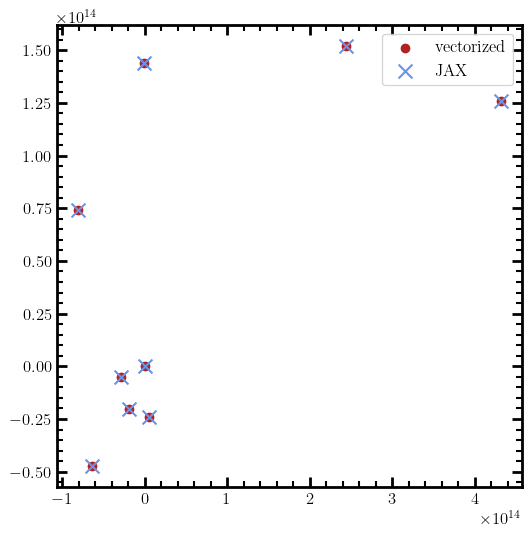

In [22]:
out_dir = './solar_system_simout_VEC_TEST'
file_path = path.join(out_dir, 'step_00009500.dat')
# Load simulation state
step_state = SimState.read(file_path)
# Get particle distribution 
dist = step_state.distribution

out_dir = './solar_system_simout_JAX_TEST'
file_path = path.join(out_dir, 'step_00009500.dat')
# Load simulation state
step_state = SimState.read(file_path)
# Get particle distribution 
dist2 = step_state.distribution


# Plot x and y in cm 
plt.scatter(dist.x, dist.y, label="vectorized",c='firebrick')
plt.scatter(dist2.x, dist2.y, label="JAX", marker='x', c='cornflowerblue', s=100)
plt.legend()
plt.show()